# config

In [1]:
dConfigActiveLearning = { 'init_oversampling_rate': 8,
                          'init_weak_label_ratio': 0.1,
                              'backup_threshold': 0.2 }

dConfig = { 
            #'skipCells': [''], 
            'skipCells':  [ 'active learning loop','preparation for active learning','NO ACTIVE LEARNING-THRESHOLD','NO ACTIVE LEARNING-OVERSAMPLING', 'NO ACTIVE LEARNING-TRAIN_WEAK', 'TEST-MIXTRAINANDWEAK', 'TRAIN-BASEMODEL' ], 
            'keywords': ['Deep Learning'],
            #'threshold': 0.15, #0.3 is better but then no active learning is required
            'query_count': 10,
            'max_annoatations': 100,
            'test_size': 0.2,
            #'datasets': [],
            #'metrics': [] 
            }

def runCell(name):
    return (len(dConfig['skipCells']) == 0) or (np.array(dConfig['skipCells']) == name).sum() == 0

# imports 

In [2]:
import collections.abc
collections.Iterable = collections.abc.Iterable

from sentence_transformers import SentenceTransformer

# import collections.abc
# collections.Iterable = collections.abc.Iterable
from domain_classifier.classifier import CorpusClassifier
from domain_classifier.active_learner import ActiveLearner
from domain_classifier.query_strategy import *

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
# 
import pandas as pd
import numpy as np

import pickle
import os
from pathlib import Path
import json
import time
import sys

import matplotlib.pyplot as plt

#USE ENTIRE SCREEN
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# functions

In [3]:
def read_corpus():
    df_corpus = pd.read_feather('data/given/corpus.feather')
    df_corpus.loc[:,['text']] = (df_corpus['title'] + '. '+ df_corpus['description'])
    df_corpus.drop(['acronym', 'title', 'description'], inplace=True, axis=1)
    return df_corpus
def get_true_annotations(df_dataset,keywords):
    return  df_dataset['text'].str.contains(keywords[0]) * 1 
def get_weak_soft_labels(df_dataset,keywords):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    #embeddings_fname = getPath('embeddings')
    embeddings_fname = Path('data/activeLearning/embeddings/embeddings.pkl')
    embeddings_fname.parent.mkdir(parents=True, exist_ok=True)
    if embeddings_fname.exists():
        with open(embeddings_fname, "rb") as f_in:
            doc_embeddings = pickle.load(f_in)
    else:
        n_docs = len(df_dataset['text'].to_numpy())
        batch_size = 32
        doc_embeddings = model.encode(df_dataset['text'].values[0:n_docs],batch_size=batch_size,show_progress_bar=True)
        with open(embeddings_fname, 'wb') as f_Out:
            print('5')
            pickle.dump(doc_embeddings,f_Out)

    keyword_embeddings = model.encode(keywords)
    distances = cosine_similarity(doc_embeddings, keyword_embeddings)
    return np.mean(distances, axis=1)
def get_weak_labels(df_dataset,keywords,threshold):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    #embeddings_fname = getPath('embeddings')
    embeddings_fname = Path('data/activeLearning/embeddings/embeddings.pkl')
    embeddings_fname.parent.mkdir(parents=True, exist_ok=True)
    if embeddings_fname.exists():
        with open(embeddings_fname, "rb") as f_in:
            doc_embeddings = pickle.load(f_in)
    else:
        n_docs = len(df_dataset['text'].to_numpy())
        batch_size = 32
        doc_embeddings = model.encode(df_dataset['text'].values[0:n_docs],batch_size=batch_size,show_progress_bar=True)
        with open(embeddings_fname, 'wb') as f_Out:
            print('5')
            pickle.dump(doc_embeddings,f_Out)

    keyword_embeddings = model.encode(keywords)
    distances = cosine_similarity(doc_embeddings, keyword_embeddings)
    scores = np.mean(distances, axis=1)
    return (scores>threshold)*1 
def get_is_test(df_dataset,test_size=0.2):
    X_train, X_test = train_test_split( df_dataset, test_size=test_size, random_state=42, stratify = df_dataset['true_annotation'].to_numpy())
    is_test = np.ones(len(df_dataset), dtype=bool)
    is_test[X_train.index] = False
    return is_test
def reduce_data(df_dataset,factor = 0.1):
    X_train, X_test = train_test_split( df_dataset, test_size=factor, random_state=42, stratify = df_dataset['true_annotation'].to_numpy())
    return X_test.reset_index(drop=True)
def oversample_minority_class(df_dataset,oversampling_rate=10,col_label='labels'):
    if oversampling_rate < 0:
        oversampling_rate = 10**10
    iPositiveCount = df_dataset.loc[:][col_label].sum()
    iNegativeCount = len(df_dataset)-iPositiveCount
    iClassCount = int(oversampling_rate * np.min([iPositiveCount,iNegativeCount]))
    iClassCount = int(np.min([iClassCount,np.max([iPositiveCount,iNegativeCount])]))
    oversampling_rate = iClassCount/np.min([iPositiveCount,iNegativeCount])
    
    condition_positive = df_dataset.loc[:][col_label]==1
    condition_negative = df_dataset.loc[:][col_label]==0
    df_positive = df_dataset[condition_positive]
    df_negative = df_dataset[condition_negative]
    
    n_repeat = iClassCount // len(df_positive)
    idx_positive = df_positive.loc[df_positive.index.repeat(n_repeat)].index
    n_sample = np.mod(iClassCount,len(df_positive))
    idx_positive = np.concatenate([idx_positive,df_positive[:n_sample].index])
    #idx_positive = np.concatenate([idx_positive,df_positive.sample(n_sample).index])
    
    n_repeat = iClassCount // len(df_negative)
    idx_negative = df_negative.loc[df_negative.index.repeat(n_repeat)].index
    n_sample = np.mod(iClassCount,len(df_negative))
    idx_negative = np.concatenate([idx_negative,df_negative[:n_sample].index])
    #idx_negative = np.concatenate([idx_negative,df_negative.sample(n_sample).index])
    
    indices = np.hstack([idx_positive,idx_negative])
    return [df_dataset.loc[indices].reset_index(drop=True),oversampling_rate]   #[df_dataset.loc[indices].sample(frac=1).reset_index(drop=True),oversampling_rate]
def save_dataset(df_dataset,path):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    df_dataset.to_csv(path)
def print_positive_negative_labels(ds):
    positive = ds.sum().to_numpy()[0]
    negative = len(ds) - positive
    print(f'Positive/Negative: { positive }/{ negative }')
def read_results():
    cProtocols = []
    pPath = Path(f'data/activeLearning/protocols/')
    for fileName in os.listdir(pPath):
        try:
            path = f'{ pPath }\{ fileName }'
            file = open(path)
            dData = json.load(file)
            cProtocols.append(dData['data'])
        except:
            pass
    return cProtocols

def plot_results(cProtocol=None):
    cProtocols = []
    if(cProtocol == None):
        #read from file system
        pPath = Path(f'data/activeLearning/protocols/')
        for fileName in os.listdir(pPath):
            try:
                path = f'{ pPath }\{ fileName }'
                file = open(path)
                dData = json.load(file)
                cProtocols.append(dData['data'])
            except:
                pass
    else:
        cProtocols = [cProtocol]

     ##############################Evaluation##############################
    for cProtocol in cProtocols:
        anotations = [x1['annotations'] for x1 in cProtocol]
        #f1s = [x1['f1'] for x1 in cProtocol]
        f1s = [float(x1['f1_score']) for x1 in cProtocol]
        #trainIds = np.array([x1['trainId'] for x1 in cProtocol])
        fig = plt.figure(figsize=(30,6))#figsize=(15,4)
        #ax1 = fig.add_subplot(111)
        plt.ylabel('F1 Score', color='blue')
        plt.xlabel('Annotations')
        plt.ylim([0,1.1])
        plt.plot(anotations,f1s)
        plt.xticks(rotation=45)
        plt.legend(['F1 Score'])
        plt.title(f'Annotations vs. F1 Score')
        plt.show()

# Short cut( can be ignored)

In [4]:
# if runCell('Short cut'):
#     path = Path('data/activeLearning/dataset/active_learning.csv')
#     df_dataset = pd.read_csv(path)
#     clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
#     clf.load('pretrained_model.pt')

# prepare data for active learning

In [5]:
# if runCell('prepare data for active learning'):
#     df_corpus = read_corpus()
#     df_dataset = df_corpus
#     df_dataset.insert(2,'true_annotation',get_true_annotations(df_dataset,dConfig['keywords']))    
#     df_dataset.insert(3,'weak_soft_label',get_weak_soft_labels(df_dataset,dConfig['keywords']))
#     df_dataset.insert(4,'is_test',get_is_test(df_dataset,dConfig['test_size']))
#     df_dataset.insert(5,'annotation_idx',-1)
#     save_dataset(df_dataset,'data/activeLearning/dataset/active_learning.csv')
df_dataset = pd.read_csv('data/activeLearning/dataset/active_learning.csv')

# pu training with weak labels (uncommented hence integrated in active learning class)

In [6]:
# if runCell('pu training with weak labels'):
#     clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
#     df_train_org = pd.DataFrame({ 'id': df_dataset['id'],'text': df_dataset['text'],'labels': df_dataset['weak_label'] } )
#     df_train = oversample_minority_class(df_train_org,max_oversampling=1)
#     clf.train_loop(df_train,epochs=1) #trainloader
#     clf.save('pretrained_model.pt')

# preparation for active learning

In [7]:
if runCell('preparation for active learning'):
    df_test = df_dataset[df_dataset['is_test']]
    df_active_learning = df_dataset[df_dataset['is_test'] == False]
    df_test = pd.DataFrame({ 'id': df_test['id'],'text': df_test['text'],'labels': df_test['true_annotation'] } )
    df_test = oversample_minority_class(df_test,oversampling_rate=1)
    
    queryStrategy = WeakSoftLabelTrustSampling()
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    active_learner = ActiveLearner(clf,queryStrategy,df_active_learning[['id','text','weak_soft_label','annotation_idx']], dConfig = dConfigActiveLearning )

# active learning loop

In [8]:
if runCell('active learning loop'):
    cProtocol = []
    annotation_count = 0
    while True:
        
        #query new samples by sample strategy
        indices_queried = active_learner.query(dConfig['query_count'])
        
        # abort condition
        if (len(indices_queried) == 0) or (dConfig['max_annoatations'] <= annotation_count):
            break
        annotation_count += dConfig['query_count']
          
        # Simulate user interaction here. Replace this for real-world usage.
        y = df_dataset.loc[indices_queried, ['true_annotation']].to_numpy().flatten()

        active_learner.update(y)
        
        result = active_learner.eval(df_test)
        
        lastProtocol = active_learner.getProtocol()[-1]
        print(f'Evaluation against all test data{lastProtocol}')  
         
    #save_results(cProtocol)
    active_learner.saveProtocol()

# plot it

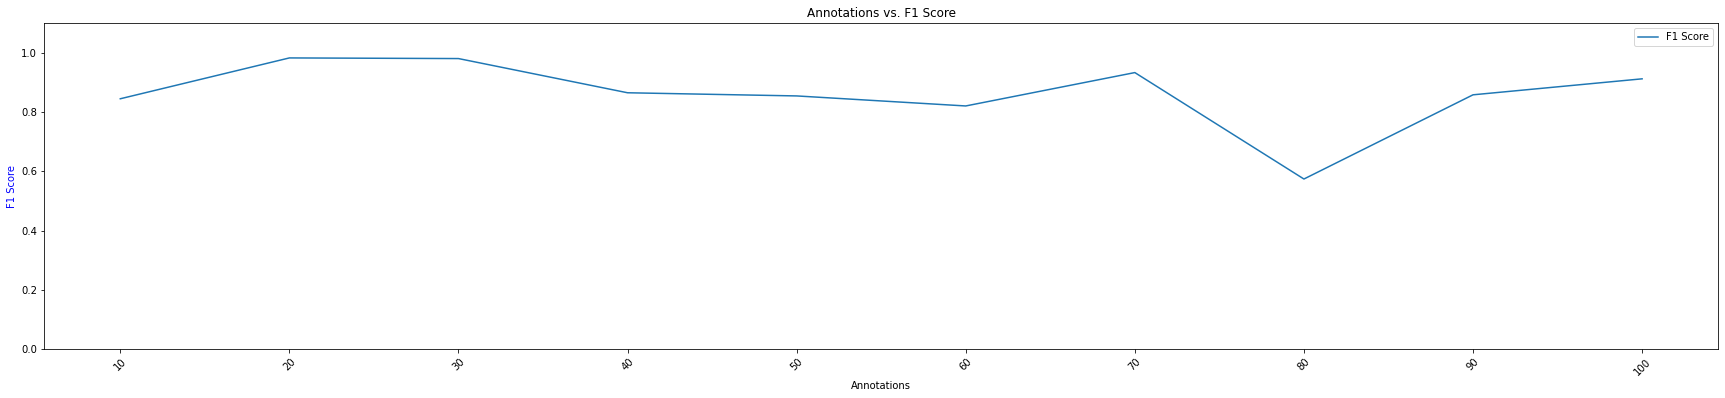

In [9]:
if runCell('plot it'):
    #RESULT HANDLING
    plot_results() 

In [10]:
# protocol = read_results()[0]
# clf_idx = 0
# active_learning_iterration_idx = 0
# active_learning_iterration = protocol[active_learning_iterration_idx]

# clf_shorts = [ {'f1_score': clf['f1_score'],'is_query_lead': clf['is_query_lead'],'weak_label_threshold': clf['weak_label_threshold'],'weak_label_ratio': clf['weak_label_ratio'],'oversampling_rate': clf['oversampling_rate']} for clf in active_learning_iterration['classifiers']]
# print(active_learning_iterration['f1_score'])
# [print(clf_short) for clf_short in  clf_shorts]

In [11]:
# true_idxs = active_learning_iterration['classifiers'][clf_idx]['true_idxs']
# weak_idxs = active_learning_iterration['classifiers'][clf_idx]['weak_idxs']
# test_idxs = active_learning_iterration['classifiers'][clf_idx]['test_idxs']
# threshold = float(protocol[active_learning_iterration_idx]['classifiers'][clf_idx]['weak_label_threshold'])

# df_true_label = pd.DataFrame(df_dataset.loc[true_idxs][['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
# df_true_label['labels'] = df_true_label['labels'].astype('int')

# df_weak_label = pd.DataFrame(df_dataset.loc[true_idxs][['id','text','weak_soft_label']].to_numpy(),columns=['id','text','labels'])
# df_weak_label.loc[df_weak_label[df_weak_label['labels'] <= threshold].index,['labels']] = 0
# df_weak_label.loc[df_weak_label[df_weak_label['labels'] > threshold].index,['labels']] = 1
# df_weak_label['labels'] = df_weak_label['labels'].astype('int')


# df_test_true_label = pd.DataFrame(df_dataset.loc[test_idxs][['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
# df_test_true_label['labels'] = df_test_true_label['labels'].astype('int')

# df_train_mix = pd.concat([df_true_label,df_weak_label])
# clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
# clf.train_loop(df_train_mix, df_test_true_label)

# result = clf.eval(df_test)
# print(result)

In [12]:
# result = clf.predict_proba(df_test)
# print(result)

In [13]:
# df_test = df_dataset[df_dataset['is_test']]
# df_active_learning = df_dataset[df_dataset['is_test'] == False]
# df_test = pd.DataFrame({ 'id': df_test['id'],'text': df_test['text'],'labels': df_test['true_annotation'] } )
# df_test = oversample_minority_class(df_test,max_oversampling=1)
#result = clf.eval(df_test)

In [14]:
#TEST NO ACTIVE LEARNING? WEAK LABEL THRESHOLD
if runCell('NO ACTIVE LEARNING-THRESHOLD'): 
    amount_weak_true_labels = [30,50,100]
    max_train_data_size = 10000

    df_test = df_dataset[df_dataset['is_test']]
    df_test = pd.DataFrame({ 'id': df_test['id'],'text': df_test['text'],'labels': df_test['true_annotation'] } )

    for amount_weak_true_label in amount_weak_true_labels:
        print(f'##############################START {amount_weak_true_label}##############################')
        df_train = df_dataset[df_dataset['is_test']==False]
        df_train = pd.DataFrame({ 'id': df_train['id'],'text': df_train['text'],'labels': df_train['weak_soft_label'] } )

        threshold = df_train.sort_values(by=['labels'],ascending=False)['labels'].iloc[amount_weak_true_label]
        df_train.loc[df_train[df_train['labels'] > threshold].index,['labels']] = 1
        df_train.loc[df_train[df_train['labels'] <= threshold].index,['labels']] = 0
        df_train['labels'] = df_train['labels'].astype('int')

        check_count = len(df_train[df_train['labels']==1])
        print(f'check:{check_count}')

        oversampling_rate = max_train_data_size// amount_weak_true_label
        #1,10,100,919(max)
        df_train,oversampling_rate = oversample_minority_class(df_train,oversampling_rate=oversampling_rate)
        clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
        clf.train_loop(df_train, df_test)



    len(df_train)

    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.train_loop(df_train, df_test)


In [15]:
#TEST NO ACTIVE LEARNING? OVERSAMPLING THRESHOLD
if runCell('NO ACTIVE LEARNING-OVERSAMPLING'):
    oversampling_rate = 200
    df_test = df_dataset[df_dataset['is_test']]
    df_test = pd.DataFrame({ 'id': df_test['id'],'text': df_test['text'],'labels': df_test['true_annotation'] } )
    df_train = df_dataset[df_dataset['is_test']==False]
    df_train = pd.DataFrame({ 'id': df_train['id'],'text': df_train['text'],'labels': df_train['true_annotation'] } )
    df_train,oversampling_rate = oversample_minority_class(df_train,oversampling_rate=oversampling_rate)
    len(df_train)
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.train_loop(df_train, df_test)

In [16]:
#TEST NO ACTIVE LEARNING? OVERSAMPLING THRESHOLD
def buildTestSet(df_annotated,df_dataset,threshold):
    n_positive = len(df_dataset[df_dataset['weak_soft_label']>threshold])
    n_negative = len(df_dataset[df_dataset['weak_soft_label']<=threshold])
    negative_ratio = n_negative/n_positive
    
    df_positive = df_annotated[df_annotated['labels']==1]
    df_negative = df_annotated[df_annotated['labels']==0]

    if negative_ratio > 1:
        n = int(len(df_positive) * negative_ratio)
        df_negative_samples = df_negative.sample(n,replace=True)
        df_positive_samples = df_positive
    else:
        n = int(len(df_negative) / negative_ratio)
        df_positive_samples = df_negative.sample(n,replace=True)
        df_negative_samples = df_positive
    return pd.concat([df_positive_samples,df_negative_samples])
    

if runCell('NO ACTIVE LEARNING-TRAIN_WEAK'):
    #GET MAX FScore after 1. Iterration (base model)
    df_al_test = df_dataset[df_dataset['is_test']]
    df_al_test = pd.DataFrame(df_al_test[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
    df_al_test['labels'] = df_al_test['labels'].astype('int')

    df_al = df_dataset[df_dataset['is_test']==False].sort_values(by=['weak_soft_label'],ascending=False)
    df_annotation = pd.concat([df_al[:5],df_al[-5:]])
    threshold = np.mean([np.mean(df_annotation[df_annotation['true_annotation']==1]['weak_soft_label']),np.mean(df_annotation[df_annotation['true_annotation']==0]['weak_soft_label'])])
    df_annotation = pd.DataFrame(df_annotation[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
    df_annotation['labels'] = df_annotation['labels'].astype('int')
    df_test = buildTestSet(df_annotation,df_al,threshold)

    df_train = df_al[5:]
    df_train = df_train[:-5]
    df_train = pd.DataFrame(df_train[['id','text','weak_soft_label']].to_numpy(),columns=['id','text','labels'])
    df_train.loc[df_train[df_train['labels'] > threshold].index,['labels']] = 1
    df_train.loc[df_train[df_train['labels'] <= threshold].index,['labels']] = 0
    df_train['labels'] = df_train['labels'].astype('int')

    df_train,_ = oversample_minority_class(df_train,20)

    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.train_loop(df_train, df_test)

In [17]:
#TEST NO ACTIVE LEARNING? MIX WEAK LABELS AND TRUE LABELS
if runCell('TEST-MIXTRAINANDWEAK'):
    df_al_test = df_dataset[df_dataset['is_test']]
    df_al_test = pd.DataFrame(df_al_test[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
    df_al_test['labels'] = df_al_test['labels'].astype('int')

    df_al = df_dataset[df_dataset['is_test']==False].sort_values(by=['weak_soft_label'],ascending=False)
    df_annotation1 = pd.concat([df_al[:5],df_al[-5:]])
    df_annotation = df_annotation1
    threshold = np.mean([np.mean(df_annotation[df_annotation['true_annotation']==1]['weak_soft_label']),np.mean(df_annotation[df_annotation['true_annotation']==0]['weak_soft_label'])])
    df_annotation = pd.DataFrame(df_annotation[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
    df_annotation['labels'] = df_annotation['labels'].astype('int')

    df_train_true, df_test = train_test_split( df_annotation, test_size=0.5, random_state=42, stratify = df_annotation['labels'].to_numpy())

    df_train_weak = df_al[5:]
    df_train_weak = df_train_weak[:-5]
    df_train_weak = pd.DataFrame(df_train_weak[['id','text','weak_soft_label']].to_numpy(),columns=['id','text','labels'])
    df_train_weak.loc[df_train_weak[df_train_weak['labels'] > threshold].index,['labels']] = 1
    df_train_weak.loc[df_train_weak[df_train_weak['labels'] <= threshold].index,['labels']] = 0
    df_train_weak['labels'] = df_train_weak['labels'].astype('int')
    df_train_weak,_ = oversample_minority_class(df_train_weak,-1)

    df_train_true,_ = oversample_minority_class(df_train_true,-1)
    df_test = buildTestSet(df_test,df_al,threshold)

    cLog = []
    cLog2 = []
    n_true = len(df_train_true)
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    f1_train = clf.train_loop(df_train_true, df_test)
    result = clf.eval(df_al_test)
    cLog.append({**{'n_true_label':str(n_true), 'repeat': str(1), 'n_weak': str(0), 'f1_train': str(f1_train), 'f1_eval': result['f1_cont']},**result})
    cLog2.append({'n_true_label':str(n_true), 'repeat': str(1), 'n_weak': str(0), 'f1_train': str(f1_train), 'f1_eval': result['f1_cont']})
    print(cLog[-1])
    for n_weak in [10,100,1000,10000,100000]:
        n_weak2 = int(np.ceil(n_weak/n_true) * n_true)

        max_repeats = n_weak2 // n_true
        repeats = [1, max_repeats]
        if max_repeats > 2:

            repeats = [1, int(np.sqrt(max_repeats)), max_repeats]

        if n_weak < 100000:
            test_size = n_weak2*1.01 / len(df_train_weak)
            _, df_train_weak_set = train_test_split( df_train_weak, test_size=test_size, random_state=42, stratify = df_train_weak['labels'].to_numpy())
            df_train_weak_set = df_train_weak_set[:n_weak2]
        else:
            df_train_weak_set = df_train_weak

        for repeat in repeats:
            df_train = pd.concat([df_train_true.loc[df_train_true.index.repeat(repeat)],df_train_weak_set])
            clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
            f1_train = clf.train_loop(df_train, df_test)
            result = clf.eval(df_al_test)
            cLog.append({**{'n_true_label':n_true, 'repeat': repeat, 'n_weak': n_weak2, 'f1_train': f1_train, 'f1_eval': result['f1_cont']},**result})
            cLog2.append({'n_true_label':n_true, 'repeat': repeat, 'n_weak': n_weak2, 'f1_train': f1_train, 'f1_eval': result['f1_cont']})
            print(cLog[-1])

    import json
    dProtocol = { 'data': cLog2 }
    protocolPath = Path(f'data/activeLearning/trueweakmix/trueweakmix.json')
    protocolPath.parent.mkdir(parents=True, exist_ok=True)
    with open(protocolPath,'w') as outfile:
        json.dump(dProtocol, outfile)


    cLog = []



In [18]:
#CREATE BASE MODEL
df_al_test = df_dataset[df_dataset['is_test']]
df_al_test = pd.DataFrame(df_al_test[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
df_al_test['labels'] = df_al_test['labels'].astype('int')

df_al = df_dataset[df_dataset['is_test']==False].sort_values(by=['weak_soft_label'],ascending=False)
df_annotation1 = pd.concat([df_al[:5],df_al[-5:]])
threshold = np.mean([np.mean(df_annotation1[df_annotation1['true_annotation']==1]['weak_soft_label']),np.mean(df_annotation1[df_annotation1['true_annotation']==0]['weak_soft_label'])])
df_annotation1 = pd.DataFrame(df_annotation1[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
df_annotation1['labels'] = df_annotation1['labels'].astype('int')

df_train_true1, df_test1 = train_test_split( df_annotation1, test_size=0.5, random_state=42, stratify = df_annotation1['labels'].to_numpy())

df_test = df_test1

df_train_weak = df_al[5:]
df_train_weak = df_train_weak[:-5]
df_train_weak = pd.DataFrame(df_train_weak[['id','text','weak_soft_label']].to_numpy(),columns=['id','text','labels'])
df_train_weak.loc[df_train_weak[df_train_weak['labels'] > threshold].index,['labels']] = 1
df_train_weak.loc[df_train_weak[df_train_weak['labels'] <= threshold].index,['labels']] = 0
df_train_weak['labels'] = df_train_weak['labels'].astype('int')
df_train_weak,_ = oversample_minority_class(df_train_weak,-1)

df_train_true1,_ = oversample_minority_class(df_train_true1,-1)
df_test = buildTestSet(df_test,df_al,threshold)

In [20]:
#TRAIN BASE MODEL
#if runCell('TRAIN-BASEMODEL'):
if 1 == 1:
    cLog = []
    cLog2 = []
    n_true = len(df_train_true1)
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    f1_train = clf.train_loop(df_train_weak, df_test)
    result = clf.eval(df_al_test)
    cLog.append({**{'n_true_label':str(n_true), 'repeat': str(1), 'n_weak': str(0), 'f1_train': str(f1_train), 'f1_eval': result['f1_cont']},**result})
    cLog2.append({'n_true_label':str(n_true), 'repeat': str(1), 'n_weak': str(0), 'f1_train': str(f1_train), 'f1_eval': result['f1_cont']})
    print(cLog[-1])

    import json
    dProtocol = { 'data': cLog2 }
    protocolPath = Path(f'data/activeLearning/trueweakmix/baseModel.json')
    protocolPath.parent.mkdir(parents=True, exist_ok=True)
    with open(protocolPath,'w') as outfile:
        json.dump(dProtocol, outfile)

KeyboardInterrupt: 

In [ ]:
#TRAIN BASE MODEL WITH TRUE ANNOTATIONS
if 1 == 2:
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.load('base_model.pt')
    clf.train_loop(df_train_true1,df_test)
    clf.eval(df_al_test)
#QUERY
if 1 == 1:
    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.load('FIRSTROUND.pt')
    df_unlabeled = df_al[5:]
    df_unlabeled = df_unlabeled[:-5]
    df_unlabeled = pd.DataFrame(df_unlabeled[['id','text','true_annotation']].to_numpy(),columns=['id','text','labels'])
    print('hier')
    df_unlabeled['labels'] = df_unlabeled['labels'].astype('int')
    predictions = clf.predict_proba(df_unlabeled)
#     idx_least_confidence = np.argsort(np.abs(predictions-0.5))[:10]
#     test = clf.predict_proba(df_unlabeled.loc[idx_least_confidence])

# df_al[:5],df_al[-5:]


In [ ]:
#SAVE

In [ ]:
idx_least_confidence = np.argsort(np.abs(predictions-0.5))[:10]
# print(predictions[idx_least_confidence])

test = clf.predict_proba(df_unlabeled[:10])
test

In [ ]:
predictions[0:10]



In [ ]:
clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
clf.load('FIRSTROUND.pt')
print(predictions[0])
test = clf.predict_proba(df_unlabeled.iloc[[1]])
test

In [ ]:
#SECOND ROUND
if 1 == 1:
    df_annotation2 = df_unlabeled.loc[idx_least_confidence]
    df_annotation = df_dataset.loc[np.concatenate([df_al[:5].index,df_al[-5:].index,df_annotation2.index])]
    threshold = np.mean([np.mean(df_annotation[df_annotation['true_annotation']==1]['weak_soft_label']),np.mean(df_annotation[df_annotation['true_annotation']==0]['weak_soft_label'])])    

    df_train_true2, df_test2 = train_test_split( df_annotation2, test_size=0.5, random_state=42, stratify = df_annotation1['labels'].to_numpy())

    df_train_true = pd.concat([df_train_true1,df_train_true2])
    df_train_true,_ = oversample_minority_class(df_train_true,-1)

    print(len(df_train_true))

    df_test = pd.concat([df_test1,df_test2])
    df_test = buildTestSet(df_test,df_al,threshold)

    clf = CorpusClassifier(path2transformers=Path('data/activeLearning/models'))
    clf.load('FIRSTROUND.pt')
    clf.train_loop(df_train_true,df_test)
    clf.eval(df_al_test)

In [ ]:
#CHANGE BASE MODEL BY ANNOTATIONS AND THERSHOLD
#WHAT IS THE TRUE_THRESHOLD?

df_al_test_full = df_dataset[df_dataset['is_test']]

#0.063618753000912
print(threshold)

true_threshold_test = np.mean([np.mean(df_al_test_full[df_al_test_full['true_annotation']==1]['weak_soft_label']),np.mean(df_al_test_full[df_al_test_full['true_annotation']==0]['weak_soft_label'])])
print(true_threshold_test)
true_threshold_train = np.mean([np.mean(df_al[df_al['true_annotation']==1]['weak_soft_label']),np.mean(df_al[df_al['true_annotation']==0]['weak_soft_label'])])
print(true_threshold_train)

#train base model with annotation : check change
# f1_train = clf.train_loop(df_train_true, df_test)
# result = clf.eval(df_al_test)

#THRESHOLDS

#if I change the threshold towards the true threshold is the f1 score getting better during training
#if I change the threshold towards the true threshold is the f1 score getting better during evaluation
# n_positive_best = len(df_al[df_al['weak_soft_label']>threshold])
# n_positive_true = len(df_al[df_al['weak_soft_label']>true_threshold_test])
# changeRates = np.arange(0,10) * ((n_positive_true-n_positive_best)/10)
# nPositive_count = n_positive_best
# for changeRate in changeRates:
#     nPositive_count += changeRate



In [ ]:
np.mean(df_al_test_full[df_al_test_full['true_annotation']==0]['weak_soft_label'])